先过一下理论，随后整理代码

#### 1. What does a neuron compute?
Within an artificial neural network, a neuron is a mathematical function that model the functioning of a biological neuron. Typically, a neuron compute the weighted average of its input, and this sum is passed through a nonlinear function, often called activation function.

A hidden layer maps input features to  new features,which are computed by neurons that one neuron output/represent one new feature.

####  2. Why we use non-linear activation funcitons in neural networks?
Non-linear functions address the problems of a linear activation function: They allow backpropagation because they have a derivative function which is related to the inputs. They allow “stacking” of multiple layers of neurons to create a deep neural network.

Without non-linear activation funciton,no matter how deep the network is,it's the same as one layer on account of “stacking”.

#### 3. What is the 'Logistic Loss' ?

 The loss function of logistic regression is doing this exactly which is called Logistic Loss.
 
$$L(\hat{y} ,y) = -y log(\hat{y})-(1-y)log(1-\hat{y})$$
$\hat{y}$ is the predicted value and y is the label value.
Intuitively, we want to assign more punishment when predicting 1 while the actual is 0 and when predict 0 while the actual is 1.

#### 4. Assume that you are building a binary classifier for detecting if an image containing cats, which activation functions would you recommen using for the output layer ?

A. ReLU    

B. Leaky ReLU  

C. sigmoid         ✔ 

D. tanh  

#### 5. Why we don't use zero initialization for all parameters ?
If you initialize all weights with zeros,then every hidden unit will get zero independent of the input. So, when all the hidden neurons start with the zero weights, then all of them will follow the same gradient and for this reason "it affects only the scale of the weight vector, not the direction".

Initializing all weights with a same value doesn't work,either.

#### 6. Can you implement the softmax function using python ? 
Sure,let's go.

# 先看下我们使用到的数据集

In [2]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
digits = datasets.load_digits()

In [4]:
#1797个样本，每个样本8x8的像素
digits.data.shape

(1797, 64)

In [5]:
#这里存的是样本的label
digits.target.shape

(1797,)

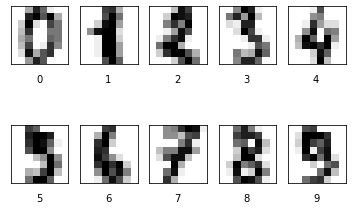

In [15]:
for i in range(1,11):
    plt.subplot(2,5,i)
    #数据集前9个数据正好是1~9
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    #（3，10）为文本位置的坐标。每个框的左上角是（0，0），下边框是8因为像素是8x8
    plt.text(3,10,str(digits.target[i-1]))
    #关闭坐标轴刻度
    plt.xticks([])
    plt.yticks([])
plt.show()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1347, 64)
(450, 64)
(1347,)
(450,)


# 接下来是几种运算的正向传播和反向传播

## linear/affine

### 正向

 $$ z = w^T * x +b $$ 

In [25]:
def affine_forward(x, w, b):
  """
  输入：
  x的维度为(N, d_1, ..., d_k)。N是batchsize，每个样本有k个特征。我们可以将其reshape为（N，D）
  w的维度为(D, M)，M为下一层神经元的个数(对应输出维度)
  b的维度为(M,)
  输出：
  out的维度为(N, M)，作为下一层的输入
  cache元组(x, w, b)存下反向传播中可以直接导入计算梯度
  """
  out = None
  N, D = x.shape[0], x.size / x.shape[0]
  out = np.dot(x.reshape(N, D), w) + b
  cache = (x, w, b)
  return out, cache

### 反向

$$ \frac{\partial{dz}}{\partial{dx}} =dz*w^T$$


$$ \frac{\partial{dz}}{\partial{dw}} =x^T*dz$$

$$ \frac{\partial{dz}}{\partial{db}} =\sum_{i=1}^{N}{dz(i,:)}$$

最后这个偏导写的pythonic了，一时想不到这个reshape数学上应该怎么写= =懂意思就行

In [38]:
def affine_backward(dz, cache):
  """
  输入:
  dz是上一层返回的梯度，这里维度视为(N, M)
  cache元组(x, w, b)为正向传播中存下的参数
  输出:
  输出为dz关于x，w，b的偏导dx，dw，db
  dx的维度为(N, d_1, ..., d_k)
  dw的维度为(D, M)
  db的维度为(M,)
  """
  x, w, b = cache
  dx, dw, db = None, None, None
  pass
  N, D = x.shape[0], w.shape[0]
  dx = np.dot(dz, w.T).reshape(x.shape)
  dw = np.dot(x.reshape(N, D).T, dz)
  db = np.sum(dz, axis = 0)

  return dx, dw, db

## RELU

这里就直接RELU吧，不用sigmoid了。下一个就是softmax

### 正向

 $$ out = RELU(z)=max(0,z)$$ 


In [27]:
def relu_forward(x):
  """
  relu就是取正数部分不用多解释啦
  """
  out = None
  out = np.maximum(0, x)
  cache = x
  return out, cache

### 反向

$$ \frac{\partial{dout}}{\partial{dx}} =dout*bool(x>0)$$

In [39]:
def relu_backward(dout, cache):
  """
  输入:
  dout:上一步反向传播回来的梯度
  cache:正向传播时记录下的参数
  输出:
  dout对于d的偏导
  """
  dx, x = None, cache

  dx = dout * (x > 0)

  return dx

## softmax loss

### 正向+反向

因为这一步是传播的终点，所以我们可以把正向和反向写在一个函数里

$$S(a_i) = \frac{e^{a_i}}{\sum_{j=1}^C e^{{a_j}}}$$

$$l=-\sum_{i=1}^{C}y^{(i)}log(S(a_i))$$

$$L=\frac{1}{N}\sum_{i=1}^{N}l$$

为了便于公式书写(否则又要写pythonic了)以上的S(a)是(1,C)的向量，y是0或1

dx反向传播求解步骤有点长这里我就不贴了，网上softmax反向传播能搜到

In [29]:
def softmax_loss(x, y):
  """
  输入:
  x的维度为(N, C)，对应N个样本C个分类。x[i, j]代表第i个样本在第j个分类的得分
  y的维度为(N,)，代表样本的label，为0~C-1的整数
  输出:
  loss是一个标量对应上面的L
  dx是loss对于x的偏导，维度(N, C)。
   
  """
  #x - np.max是为了防止数值上溢
  S = np.exp(x - np.max(x, axis=1, keepdims=True))
  #逐行对当前行求和(单个样本softmax)
  S /= np.sum(S, axis=1, keepdims=True)
  N = x.shape[0]
  #逐列对当前列求和(所有样本的损失累加)，对于每个样本每一行只有对应y列(label)的log值才会被计入损失
  loss = -np.sum(np.log(S[np.arange(N), y])) / N
  dx = S.copy()
  dx[np.arange(N), y] -= 1
  dx /= N
  return loss, dx

# 优化器

这里先只做一个SGD

## SGD

$$\theta = \theta - \alpha*d\theta$$ 

In [42]:
def sgd(w, dw, config=None):
  """
  输入:
  w就是对应公式中的θ要优化的参数，dw是当前层返回梯度，config是一个包含所有超参数的字典
  输出:
  更新过后的w
  """
  if config is None: config = {}
  config.setdefault('learning_rate', 1e-2)
  w -= config['learning_rate'] * dw
  return w, config

# 封装模型

到这里时可以思考下之后要封装的模型了。不如我们模仿Keras，按照其提供的接口来封装模型。

仿照Keras，model实例化的时候传入模型的结构，model.compile传入损失函数、优化器、学习率，model.fit传入数据集完成训练过程同时记录损失。

In [ ]:
class FullyConnected(object):
    def __init__(self, hidden_dims, input_dim=8*8, num_classes=10,
               reg=0.0, weight_scale=1e-2, dtype=np.float32):
    """
    hidden_dims为列表表示模型的结构，如[3,2,1]即代表第一层隐藏层3个神经元，第二层隐藏层2个神经元，第三层隐藏层1个神经元
    input_dim输入维度，默认对应mnist输入
    num_classes等同于输出层神经元个数，默认对应mnist类别
    reg为正则化系数
    weight_scale为系数的初始化
    dtype=np.float32代表所有系数精度为float32(也可以设为float64)

    """
    self.reg = reg
    #总层数算上输出层
    self.num_layers = 1 + len(hidden_dims)
    self.dtype = dtype
    #params字典用于存储系数
    self.params = {}
    #初始化第一层系数，这里W按照正态分布
    self.params['W1'] = np.random.randn(input_dim, hidden_dims[0]) * weight_scale
    self.params['b1'] = np.zeros(hidden_dims[0])
    #初始化第二层开始的系数
    for i in range(self.num_layers - 2):
        self.params['W' + str(i+2)] = np.random.randn(hidden_dims[i], hidden_dims[i+1]) * weight_scale
        self.params['b' + str(i+2)] = np.zeros(hidden_dims[i+1])
    #初始化最后一层的系数
    self.params['W' + str(self.num_layers)] = np.random.randn(hidden_dims[-1], num_classes)
    self.params['b' + str(self.num_layers)] = np.random.randn(num_classes)
    #确定系数精度
    for k, v in self.params.iteritems():
        self.params[k] = v.astype(dtype)

    def loss(self, x, y=None):
    """
    输入：
    x的维度为(N, d_1, ..., d_k)。N是batchsize，每个样本有k个特征。我们可以将其reshape为（N，D）
    y的维度为(N,)，代表样本的label，y也可以为None
    输出:
    当y不为None时，说明这是训练的过程，返回loss，梯度
    当y为None的时候，说明这是测试的过程，返回score
    """
    x = x.astype(self.dtype)
    mode = 'test' if y is None else 'train'
    scores = None
    #初始化两个列表，用来存每一层的输出和系数
    hidden_layers, caches = range(self.num_layers + 1), range(self.num_layers)
    hidden_layers[0] = x
    for i in range(self.num_layers):
        W, b = self.params['W' + str(i+1)], self.params['b' + str(i+1)]
        #最后一层没有RELU
        if i == self.num_layers - 1:
            hidden_layers[i+1], caches[i] = affine_forward(hidden_layers[i], W, b)
        else:
            a, fc_cache = affine_forward(x, w, b)
            out, relu_cache = relu_forward(a)
            cache = (fc_cache, relu_cache)
            hidden_layers[i+1], caches[i] = out, cache
    #这里的score是没经过softmax的
    scores = hidden_layers[self.num_layers]   
    
    if mode == 'test':
    return scores

    loss, grads = 0.0, {}
    loss, dscores = softmax_loss(scores, y)
    #初始化列表存储每一层梯度
    dhiddens = range(self.num_layers + 1)
    dhiddens[self.num_layers] = dscores
    for i in range(self.num_layers, 0, -1):
        #最后一层没有RELU
        if i == self.num_layers:
            dhiddens[i-1], grads['W' + str(i)], grads['b'+str(i)] = affine_backward(dhiddens[i], caches[i-1])
        else:
            dx, dw, db = affine_relu_backward(dhiddens[i], caches[i-1])
            dhiddens[i-1], grads['W' + str(i)], grads['b' + str(i)] = dx, dw, db
        #L2正则化
        loss += 0.5 * self.reg * np.sum(self.params['W' + str(i)] ** 2)
        grads['W' + str(i)] += self.reg * self.params['W' + str(i)]

    return loss, grads